# Linear regression through clustering

Sometimes outliers can seriously hinder the overall performance of regression methods based on minimisation of mean square error. The following exercise explains how to detect that there is a problem with outliers and use model based clustering to detect outliers. We also show how piecewise linear regression task where the responce to the input radically changes in a single point can be rephrased as a clustering task.    

In [1]:
import numpy as np
import pandas as pd
import numpy.random as rnd
import scipy.stats as stats
import matplotlib.pyplot as plt
import sklearn
import copy 

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

from pandas import Series
from pandas import DataFrame

from pandas import Categorical
from pandas.api.types import CategoricalDtype
from plotnine import *

from scipy.stats import norm
from scipy.stats import multivariate_normal
from scipy.stats import uniform 

# Local imports
from common import *
from convenience import *

## I. Datasets 

In this notebook we consider two challenge datasets:
* [`challenge-1.csv`](./data/gmm-regression-challenges/challenge-1.csv)
* [`challenge-2.csv`](./data/gmm-regression-challenges/challenge-2.csv)

form the directory `data/regression-challenges`.

### Challenge I. Filtering out outliers to improve polynomial fit

In the first challenge dataset, the normal polynomial response seems to be mixed with datapoints that completely random.  

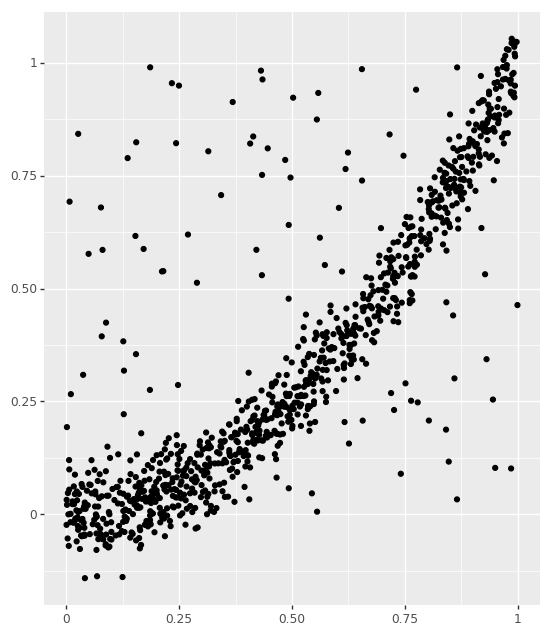

<ggplot: (7551588907)>

In [2]:
df1 = pd.read_csv('data/regression-challenges/challenge-1.csv', usecols = [1,2])

p = ggplot(df1)
p = p + geom_point(aes(x = 'x', y = 'y'))
p = p + coord_fixed()
p = p + scale_x_continuous(name='') + scale_y_continuous(name='')
display(p)

### Challenge II. Piecewise linear regression

In the second dataset, the response seem to be following a linear path but in two regimes. To find a goof fit we need to fond the location of the angle point $x_0$. 

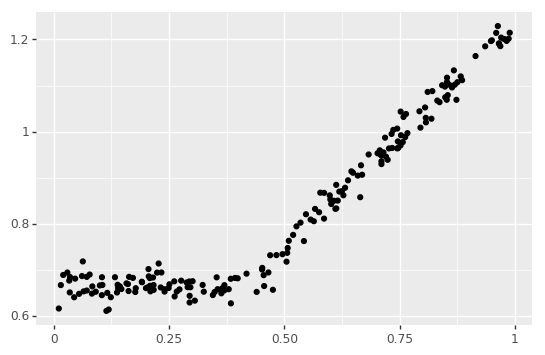

<ggplot: (7551609243)>

In [3]:
df2 = pd.read_csv('data/regression-challenges/challenge-2.csv', usecols = [1,2])

p = ggplot(df2)
p = p + geom_point(aes(x = 'x', y = 'y'))
p = p + coord_fixed()
p = p + scale_x_continuous(name='') + scale_y_continuous(name='')
display(p)

## III. General recepy for hard clustering

**Model:** Both regression tasks can be modelled as follows: 
* There are two data sources $\mathcal{D}_1$ and $\mathcal{D}_1$ with different data generation models with parameters $\boldsymbol{\Theta}_1$ and $\boldsymbol{\Theta}_2$. 
* We see only the observations $(x_1,y_1),\ldots, (x_n, y_n)$. The corresponding cluster lables $z_1,\ldots,z_n$ are unknown. 
* Our task is to find parameter values $\boldsymbol{\Theta}_1$ and $\boldsymbol{\Theta}_2$ together with labels $\boldsymbol{z}$ that are solutions to maximisation task

\begin{align*}
\Pr[\boldsymbol{y}|\boldsymbol{x},\boldsymbol{z},\boldsymbol{\Theta}_1,\boldsymbol{\Theta}_2]\to\max
\end{align*}

**First challenge dataset:**
* Both sources generate $x$ values with the same probability distribution. 
* The  source $\mathcal{D}_1$ generates responses according to the model $y\sim ax^2+bx+c+\varepsilon$ where $\varepsilon\sim\mathcal{N}(0,\sigma)$.
* The source $\mathcal{D}_2$ generates responces according to the model $y\sim \mathrm{Unif}[-M,+M]$ for some large $M$.

**The second challenge dataset:**

* The values of $x$ generated by $\mathcal{D}_1$ are in the range $(-\infty, x_0)$.
* The values of $x$ generated by $\mathcal{D}_2$ are in the range $[x_0,\infty)$.
* The  source $\mathcal{D}_i$ generates responses according to the model $y\sim a_ix+b_ix+\varepsilon$ where $\varepsilon\sim\mathcal{N}(0,\sigma)$.

**Inference:** To solve the maximisation task we can use the iterative maximisation algorithm similar to kmeans:

* **M0:** Start with random parameter values $\boldsymbol{\Theta}_1,\boldsymbol{\Theta}_2$.
* **M1:** Assign points to the most probable data source: 
  
  \begin{align*}
  \boldsymbol{z}^* =\mathrm{argmax}_{\boldsymbol{z}} \Pr[\boldsymbol{y}|\boldsymbol{x},\boldsymbol{z},\boldsymbol{\Theta}_1,\boldsymbol{\Theta}_2]
  \end{align*}
  <br>

* **M2:** Find new maximum likeloihood parameter estimates by dividing datapoints according to the label vector $\boldsymbol{z}$:

  \begin{align*}
  (\boldsymbol{\Theta}_1^*,\boldsymbol{\Theta}_2^*) =\mathrm{argmax}_{\boldsymbol{\Theta}_1,\boldsymbol{\Theta}_2} \Pr[\boldsymbol{y}|\boldsymbol{x},\boldsymbol{z},\boldsymbol{\Theta}_1,\boldsymbol{\Theta}_2]
  \end{align*}
  <br>

* Repeat steps **M1** and **M2** until covergence, i.e., when the label vector $\boldsymbol{z}$ does not change.

The only hard part is to correctly determine what are the model parameters and how to find corresponding maximum likelihood estimates. 


## IV. Naive solution to the first task

* We first fit a model $y\sim \alpha x^2+\beta$ on the data and then estimate error variance $\sigma$ form the residuals directly. Although the error distribution is far from normal distribution you can still try to find standard deviation of residuals $\sigma$ 
* Then we can approximate error distribution with $\mathcal{N}(0, \sigma)$ and compute $95\%$ confidence intervals for the error, i.e., solve the equations: 

   \begin{align*}
      \Pr[\varepsilon\gets\mathcal{N}(0,\sigma): \varepsilon\leq q_0]&=2.5\%\\
      \Pr[\varepsilon\gets\mathcal{N}(0,\sigma): \varepsilon\leq q_1]&=97.5\%
    \end{align*}
 
 and draw a plot which contains the data points, prediction line and confidence intervals
* Finally, we can declare that all points outside the confidence interval are outliers and build a new model on remaining points.  

### Step I

In [4]:
poly2 = PolynomialFeatures(degree=2)
X=DataFrame(poly2.fit_transform(df1[['x']]),columns=[r'$x^0$', r'$x1$', r'$x^2$'])
head(X)

,$x^0$,$x1$,$x^2$
0,1.0,0.728269,0.530376
1,1.0,0.909930,0.827973
2,1.0,0.380931,0.145108
3,1.0,0.245030,0.060040
4,1.0,0.626321,0.392278


In [5]:
model = LinearRegression()
model.fit(X, df1['y'])
DataFrame(model.coef_.reshape([1,3]), columns=[r'$x^0$', r'$x1$', r'$x^2$'])

,$x^0$,$x1$,$x^2$
0,0.0,0.058425,0.836538


### Step II

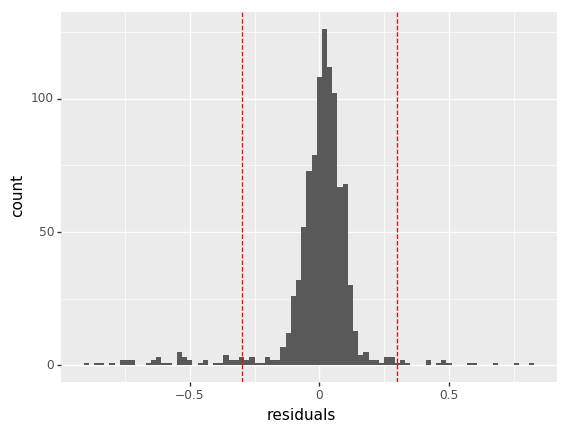

<ggplot: (7551907062)>

In [6]:
residuals = DataFrame(model.predict(X) - df1['y'].values, columns = ['residuals'])
sigma = residuals['residuals'].std()

q0 = norm.ppf(q=0.025,scale=sigma)
q1 = norm.ppf(q=0.975,scale=sigma)

p = ggplot(residuals)
p = p + geom_histogram(aes(x='residuals'), binwidth = 0.02)
p + geom_vline(aes(xintercept='x'), data=DataFrame([q0, q1], columns=['x']), color='red', linetype='--')

### Step III

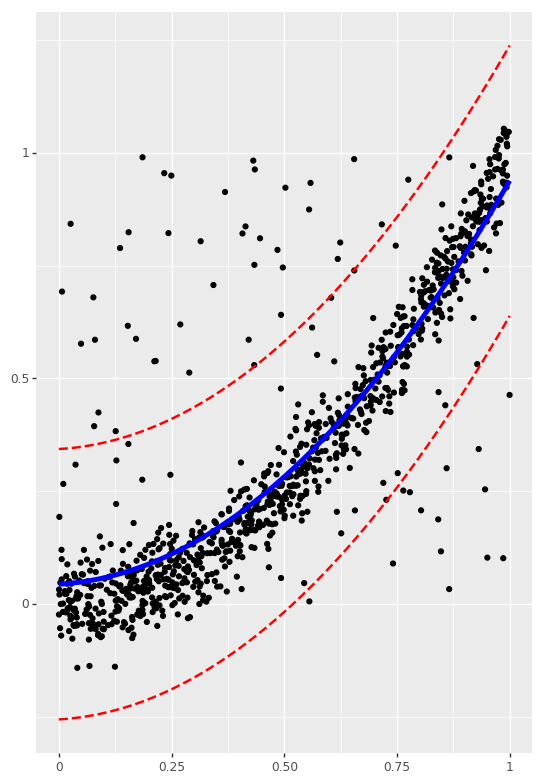

<ggplot: (7552155056)>

In [7]:
pred = (DataFrame(np.linspace(0,1,100), columns = ['x'])
        .assign(yhat = lambda df: model.predict(poly2.fit_transform(df[['x']])))
        .assign(y0 = lambda df: df['yhat'] + q0)
        .assign(y1 = lambda df: df['yhat'] + q1)
       )

p = ggplot(df1)
p = p + geom_point(aes(x = 'x', y = 'y'))
p = p + coord_fixed()
p = p + scale_x_continuous(name='') + scale_y_continuous(name='')
p = p + geom_line(aes(x = 'x', y = 'yhat'), data = pred, color = 'blue', size=2)
p = p + geom_line(aes(x = 'x', y = 'y0'), data = pred, color = 'red', size=1, linetype='--')
p = p + geom_line(aes(x = 'x', y = 'y1'), data = pred, color = 'red', size=1, linetype='--')
display(p)

## V. Naive solution for the second task

* Find an initial guess for $x_0$.
* Split data acording to $x_0$ into two clusters.
* Fit linear model on both sub-datasets.
* Choose the new $x_0$ candidate so that prediction line is contiuous.

### Step I

In [8]:
ClusterCat = CategoricalDtype([1,2], ordered=True)

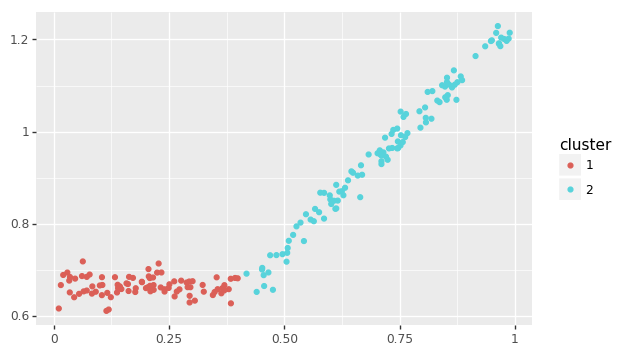

<ggplot: (-9223372036571846000)>

In [9]:
x0 = 0.4
df2 = df2.assign(cluster = lambda df: ((df['x'] >= x0) + 1).astype(ClusterCat))

p = ggplot(df2)
p = p + geom_point(aes(x = 'x', y = 'y', color ='cluster'))
p = p + coord_fixed()
p = p + scale_x_continuous(name='') + scale_y_continuous(name='')
display(p)

### Step II

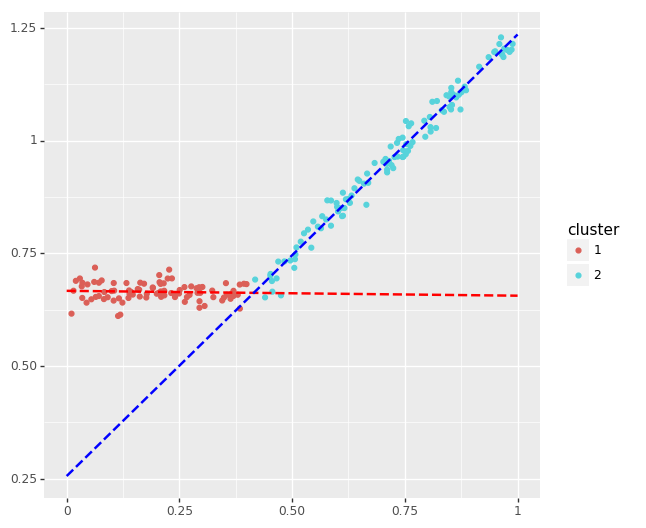

<ggplot: (-9223372029302519790)>

In [10]:
lm = LinearRegression(fit_intercept = True)
cluster1 = df2.loc[df2['cluster'] == 1]
cluster2 = df2.loc[df2['cluster'] == 2]

model1 = copy.copy(lm.fit(cluster1[['x']], cluster1['y']))
model2 = lm.fit(cluster2[['x']], cluster2['y'])

pred = (DataFrame(np.linspace(0,1,100), columns = ['x'])
        .assign(y1 = lambda df: model1.predict(df[['x']]))
        .assign(y2 = lambda df: model2.predict(df[['x']]))
       )

p = ggplot(df2)
p = p + geom_point(aes(x = 'x', y = 'y', color ='cluster'))
p = p + coord_fixed()
p = p + scale_x_continuous(name='') + scale_y_continuous(name='')
p = p + geom_line(aes(x = 'x', y = 'y1'), data = pred, color = 'red', size=1, linetype='--')
p = p + geom_line(aes(x = 'x', y = 'y2'), data = pred, color = 'blue', size=1, linetype='--')
display(p)

# Homework

## Naive implementation of robust polynomial regression (<font color='red'>1p</font>)

Write a function `naive_robust_lm` that repeats the naive outlier detection described in Subsection IV several times to fit a model. Describe the convergence criterion and demonstrate that it works also for multivariate linear regression. Compare the prediction line, means square error, and the distribution of residues for the original model and residues for the `naive_robust_lm`. Which model gives the best MSE score and why? Which model has residue distribution that is closest to the normal distribution? What is the catch in the last question? 

## Robust polynomial regression with model based clustering (<font color='red'>2p</font>)

Let us define a probabilistical model that justifies the format of the naive algoritm. Let $\mathcal{D}_1$ be the data source for which $y\sim ax^2+bx+c+\varepsilon$ for $\varepsilon\sim\mathcal{N}(0,\sigma)$. Let $\mathcal{D}_2$ be the disttibution that generates any outcome with probability $\alpha$. This distribution is called poisson component.

* Express what is the probability $p_1=\Pr[y_i|x_i, a,b,c, \sigma]$ for the first data source if all the model parameters  $a,b,c, \sigma$ are fixed. 
* Express what is the probability $p_2=\Pr[y_i|x_i,\alpha]$ for the second data source if all the model parameters $\alpha$ are fixed.
* Based on these answers implement the step **M1**.
* What is the maximum likelihood estimate for the parameters $a,b,c$ if we know the cluster labels? How can you find it?
* How can you find the maximum likelihood estimate for $\sigma$?
* Based on these answers implement the step **M2**.
* For the initial guess **M0** use linear regression to find initial estimates for the parameters $ a,b,c, \sigma$.


Implement the corresponding maximisation algorithm as `robust_lm`. Describe the convergence criterion and demonstrate that it works also for multivariate linear regression.
Show that the model indeed maximises the probability by computing the probability 

\begin{align*}
\Pr[\boldsymbol{y}|\boldsymbol{x},\boldsymbol{z},\boldsymbol{\Theta}_1,\boldsymbol{\Theta}_2]\to\max
\end{align*}

after each step. Plot the corresponding log-likelihood graph.  Compare the prediction line, means square error, and the distribution of residues for the original model and residues for the `robust_lm`. Which model gives the best MSE score and why? Which model has residue distribution that is closest to the normal distribution? What is the catch in the last question? 

## Naive implementation of piecewise linear regression (<font color='red'>1p</font>)

Write a function `naive_piecewise_lm` that repeats the naive method for the detecion of split point $x_0$
described in Subsection V several times to fit a model. Start from a worse position than we did in the section.
Describe the convergence criterion and demonstrate that it works other datasets. Show how prediction lines, means square error, and the distribution of residues evolves over iterations. 

## Piecewise linear regression with model based clustering (<font color='red'>2p</font>)

Let us define a probabilistical model that justifies the format of the naive algoritm. Let $\mathcal{D}_i$ be the data source for which $y\sim a_ix+b_i+\varepsilon$ for $\varepsilon\sim\mathcal{N}(0,\sigma)$. 

* Express what is the probability $p_i=\Pr[y_i|x_i, a_i,b_i,\sigma]$ for the data source $\mathcal{D}_i$ if all the model parameters  $a_i,b_i,\sigma$ are fixed. 
* Based on this answer implement the step **M1**.
* What is the maximum likelihood estimate for the parameters $a_i,b_i$ if we know the cluster labels? How can you find it?
* How can you find the maximum likelihood estimate for $\sigma$?
* Based on these answers implement the step **M2**.
* For the initial guess **M0** use linear regression to find initial estimates for the parameters $a,b$. Finf the split point $x_0$ so that the mean value of residues on the left and right of $x_0$ is the most distinct and there are at least 10 data points in both clusters. Any 

Implement the corresponding maximisation algorithm as `piecewise_lm`. Describe the convergence criterion and demonstrate that it works also for other datasets.
Show that the model indeed maximises the probability by computing the probability 

\begin{align*}
\Pr[\boldsymbol{y}|\boldsymbol{x},\boldsymbol{z},\boldsymbol{\Theta}_1,\boldsymbol{\Theta}_2]\to\max
\end{align*}

after each step. Plot the corresponding log-likelihood graph.  Show how prediction lines, means square error, and the distribution of residues evolves over iterations. 

